<a href="https://colab.research.google.com/github/lllllong7/Math-142-Final-Project/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Load and Merge Data

Github repository: https://github.com/lllllong7/Math-142-Final-Project

In [ ]:
# Clone the repository into Colab's temporary storage
!git clone https://github.com/lllllong7/Math-142-Final-Project.git

fatal: destination path 'Math-142-Final-Project' already exists and is not an empty directory.


In [ ]:
file_path = "Math-142-Final-Project/cleaned_lake_level:flow.xlsx"

ont = pd.read_excel(file_path, sheet_name="Lake Ontario")
niag = pd.read_excel(file_path, sheet_name="Niagara River")
stl = pd.read_excel(file_path, sheet_name="St. Lawrence River")
ott = pd.read_excel(file_path, sheet_name="Ottawa River")  # optional

# Keep only needed columns
ont = ont[["Date", "Level"]].rename(columns={"Level": "h_obs"})
niag = niag[["Date", "Flow"]].rename(columns={"Flow": "Q_in"})
stl = stl[["Date", "Flow"]].rename(columns={"Flow": "Q_out_obs"})
ott = ott[["Date", "Flow"]].rename(columns={"Flow": "Q_ott"})

# Merge on Date
df = (
    ont.merge(niag, on="Date", how="inner")
        .merge(stl, on="Date", how="inner")
        .merge(ott, on="Date", how="left")  # Ottawa optional
)

df = df.sort_values("Date").reset_index(drop=True)

In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
# nbs_raw = pd.read_excel("Math-142-Final-Project/LakeOntario_MonthlyNetBasinSupply_1900to2025.xlsx")

## Physical constants

In [ ]:
# Lake Ontario area (m^2)
A = 18_960 * 1_000_000  # km^2 to m^2

# Seconds per month (approx)
delta_t = 365.25 / 12 * 24 * 3600
alpha = delta_t / A   # Δt / A

## Infer NBS for the baseline

In [ ]:
df["h_obs_next"] = df["h_obs"].shift(-1)
df_nbs = df.dropna(subset=["h_obs_next"]).copy()

df_nbs["NBS"] = (
    (df_nbs["h_obs_next"] - df_nbs["h_obs"]) / alpha
    - df_nbs["Q_in"] + df_nbs["Q_out_obs"]
)

# Merge NBS back to main df
df = df.merge(df_nbs[["Date", "NBS"]], on="Date", how="left")

# for Models 2 and 3
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df["Month"] = df["Date"].dt.month
df["Year"]  = df["Date"].dt.year

# Monthly baseline outflow (historical)
Q_base_by_month = df.groupby("Month")["Q_out_obs"].mean()

# Monthly acceptable level bands: 10–90% of observed levels
h_min_by_month = df.groupby("Month")["h_obs"].quantile(0.10)
h_max_by_month = df.groupby("Month")["h_obs"].quantile(0.90)

# Global outflow bounds (can tweak percentiles if needed)
Q_min = df["Q_out_obs"].quantile(0.05)
Q_max = df["Q_out_obs"].quantile(0.95)

# Simple forecast of NBS: 3-month moving average shifted forward one step
df["NBS_ma3"] = df["NBS"].rolling(window=3, min_periods=1).mean().shift(-1)

# Monthly climatologies
NBS_clim_by_month = df.groupby("Month")["NBS"].mean()
Q_ott_clim_by_month = df.groupby("Month")["Q_ott"].mean()

# Pre-compute thresholds for stakeholder metrics (can adjust)
h_low  = df["h_obs"].quantile(0.10)
h_high = df["h_obs"].quantile(0.90)
h_nav  = df["h_obs"].quantile(0.20)

Q_tot_obs = df["Q_out_obs"] + df["Q_ott"]
Q_tot_crit = np.nanpercentile(Q_tot_obs, 90)

print(h_low)
print(h_high)


74.5
75.296


In [ ]:
# # Melt wide 12-month columns into long format
# nbs_long = nbs_raw.melt(
#     id_vars="Year",
#     var_name="MonthName",
#     value_name="NBS_ext"
# )

# # Clean up month names, just in case
# nbs_long["MonthName"] = nbs_long["MonthName"].str.strip()

# month_map = {
#     "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
#     "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
#     "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12,
# }

# nbs_long["Month"] = nbs_long["MonthName"].map(month_map)

# # We only need Year, Month, NBS_ext
# nbs_long = nbs_long[["Year", "Month", "NBS_ext"]]

# # Merge onto main df by Year + Month
# df = df.merge(nbs_long, on=["Year", "Month"], how="left")

# print("Fraction NBS_ext missing:", df["NBS_ext"].isna().mean())
# print(df[["Date", "Year", "Month", "NBS_ext"]].head(12))

In [ ]:
df.head()

,Date,h_obs,Q_in,Q_out_obs,Q_ott,h_obs_next,NBS,Month,Year,NBS_ma3
0,2011-12-01,74.62,6570,7560.597314,1881,74.80,2288.338587,12,2011,1754.683766
1,2012-01-01,74.80,6690,6541.190935,1924,74.99,1221.028945,1,2012,1227.072196
2,2012-02-01,74.99,6480,6796.042530,1909,74.97,171.849055,2,2012,1007.531960
3,2012-03-01,74.97,6250,8240.201567,3248,74.92,1629.717880,3,2012,1177.745317
4,2012-04-01,74.92,6040,7843.765753,2315,74.91,1731.669016,4,2012,1706.629158


# Generic Simulation Function

This function is a general lake-level simulator. It takes a dataframe with time, observed level, inflow, and NBS, plus a chosen outflow rule `Q_out_func`. Starting from the first observed level, it loops through each time step, uses `Q_out_func` to decide the outflow for that step, and then updates the lake level using the water-balance equation
$$h_{t+1} = h_t + \alpha(Q_\text{in} + NBS - Q_\text{out})$$
It stores the simulated levels and outflows in new columns h_sim and Q_out_sim and returns the updated dataframe.

In [ ]:
# After merging NBS_ext into df
df_ext = df.copy()
# df_ext["NBS"] = df_ext["NBS_ext"]      # overwrite NBS with external NBS

# Recompute NBS climatology from the external-forced dataframe
NBS_clim_by_month = df_ext.groupby("Month")["NBS"].mean()


In [ ]:
def simulate_with_rule(df, alpha, Q_out_func):
    """
    General simulator:
    - df must have columns: Date, h_obs, Q_in, NBS (and anything else Q_out_func needs)
    - Q_out_func(t, h_current, row) returns Q_out at this step
    """
    df = df.copy().sort_values("Date").reset_index(drop=True)

    h_sim = []
    Q_out_sim = []
    h_current = df["h_obs"].iloc[0]

    for t, row in df.iterrows():
        inflow = row["Q_in"]
        nbs    = row["NBS"]
        # nbs_pred = row["NBS_ma3"]
        nbs_pred = NBS_clim_by_month.loc[row["Month"]]

        Q_out_t = Q_out_func(t, h_current, row, inflow, nbs_pred)
        Q_out_sim.append(Q_out_t)

        h_sim.append(h_current)
        h_next = h_current + alpha * (inflow + nbs - Q_out_t)
        h_current = h_next

    df["h_sim"]     = h_sim
    df["Q_out_sim"] = Q_out_sim
    return df

# Define Outflow Rules (`Q_out_func`) for the Three Models

## Model 1 (Baseline Model) – Use Observed Outflow

In [ ]:
def Q_out_model1(t, h, row, inflow, nbs):
    return row["Q_out_obs"]

df_model1 = simulate_with_rule(df, alpha, Q_out_model1)

In [ ]:
df_model1.head()

,Date,h_obs,Q_in,Q_out_obs,Q_ott,h_obs_next,NBS,Month,Year,NBS_ma3,h_sim,Q_out_sim
0,2011-12-01,74.62,6570,7560.597314,1881,74.80,2288.338587,12,2011,1754.683766,74.62,7560.597314
1,2012-01-01,74.80,6690,6541.190935,1924,74.99,1221.028945,1,2012,1227.072196,74.80,6541.190935
2,2012-02-01,74.99,6480,6796.042530,1909,74.97,171.849055,2,2012,1007.531960,74.99,6796.042530
3,2012-03-01,74.97,6250,8240.201567,3248,74.92,1629.717880,3,2012,1177.745317,74.97,8240.201567
4,2012-04-01,74.92,6040,7843.765753,2315,74.91,1731.669016,4,2012,1706.629158,74.92,7843.765753


## Model 2 – Simplified “Plan-2014-Style” Regulation at Moses–Saunders

In [ ]:
k_h = 3000.0 # sensitiviity parameter

def Q_outmodel2(t, h, row, inflow, nbs):
  m = row["Month"]

  h_min = h_min_by_month.loc[m]
  h_max = h_max_by_month.loc[m]
  h_target = 0.5 * (h_min+h_max) - alpha * (inflow + nbs)

  Q_base = Q_base_by_month.loc[m]

  if h > h_max:
    Q = Q_max # lake too high then dump water

  elif h < h_min:
    Q = Q_min #Lake too low then hold water

  else:
    Q = Q_base + k_h * (h - h_target) / alpha # adjust around baseline using divation from target

  Q = float (np.clip(Q, Q_min, Q_max))
  return Q
  # safety cliiping never exceed global bounds

df_model2 = simulate_with_rule (df, alpha, Q_outmodel2)
df_model2.head()

,Date,h_obs,Q_in,Q_out_obs,Q_ott,h_obs_next,NBS,Month,Year,NBS_ma3,h_sim,Q_out_sim
0,2011-12-01,74.62,6570,7560.597314,1881,74.80,2288.338587,12,2011,1754.683766,74.620000,10211.053901
1,2012-01-01,74.80,6690,6541.190935,1924,74.99,1221.028945,1,2012,1227.072196,74.432375,6167.408596
2,2012-02-01,74.99,6480,6796.042530,1909,74.97,171.849055,2,2012,1007.531960,74.674220,10211.053901
3,2012-03-01,74.97,6250,8240.201567,3248,74.92,1629.717880,3,2012,1177.745317,74.180549,6167.408596
4,2012-04-01,74.92,6040,7843.765753,2315,74.91,1731.669016,4,2012,1706.629158,74.418050,6167.408596


Model 2 and 3 (ext NBS)


In [ ]:
# def Q_out_model1(t, h, row, inflow, nbs_pred):
#     return row["Q_out_obs"]

# df_model1 = simulate_with_rule(df_ext, alpha, Q_out_model1)


# k_h = 3000.0

# def Q_outmodel2(t, h, row, inflow, nbs_pred):
#     m = row["Month"]
#     h_min = h_min_by_month.loc[m]
#     h_max = h_max_by_month.loc[m]
#     h_target = 0.5 * (h_min + h_max) - alpha * (inflow + nbs_pred)

#     Q_base = Q_base_by_month.loc[m]

#     if h > h_max:
#         Q = Q_max
#     elif h < h_min:
#         Q = Q_min
#     else:
#         Q = Q_base + k_h * (h - h_target) / alpha

#     return float(np.clip(Q, Q_min, Q_max))

# df_model2 = simulate_with_rule(df_ext, alpha, Q_outmodel2)


# def Q_out_model3(t, h, row, inflow, nbs_pred):
#     m = row["Month"]
#     h_target = newton(h, m) - alpha * (inflow + nbs_pred)
#     Q = (h - h_target) / alpha
#     return float(np.clip(Q, Q_min, Q_max))

# df_model3 = simulate_with_rule(df_ext, alpha, Q_out_model3)


## Model 3 – Our Improved Regulation Rule

In [ ]:
k_low = 1.0   # penalty coefficient to push h lower
k_high = 1.0  # penalty coefficient to push h higher
k_dh = 1.0    # penalty coefficient on magnitude of change in h
k_env = 0.2   # environmental penalty coefficient

def newton(h_prev, m):
  def deriv(h, h_prev):
    deriv_low = k_low / (1+math.exp(-(h-h_low)))
    deriv_high = -k_high / (1+math.exp(-(h_high-h)))
    deriv_dh = 2 * k_dh * (h-h_prev)
    if m == 12 or m < 6:
      deriv_env = -k_env / (1+math.exp(-(h_high-h)))
    else:
      deriv_env = k_env / (1+math.exp(-(h-h_low)))
    return deriv_low + deriv_high + deriv_dh + deriv_env

  def hessian(h):
    hessian_low = k_low * math.exp(-(h-h_low)) / math.pow(1+math.exp(-(h-h_low)), 2)
    hessian_high = k_high * math.exp(-(h_high-h)) / math.pow(1+math.exp(-(h_high-h)), 2)
    hessian_dh = 2 * k_dh
    if m == 12 or m < 6:
      hessian_env = k_env * math.exp(-(h_high-h)) / math.pow(1+math.exp(-(h_high-h)), 2)
    else:
      hessian_env = k_env * math.exp(-(h-h_low)) / math.pow(1+math.exp(-(h-h_low)), 2)
    return hessian_low + hessian_high + hessian_dh + hessian_env

  x_prev = h_prev
  x = x_prev
  i = 0
  while(i < 50 and abs(x-x_prev) < 1e-4):
    new = x - deriv(x, x_prev) / hessian(x)
    x_prev = x
    x = new
    i += 1
  return x


def Q_out_model3(t, h, row, inflow, nbs):
  m = row["Month"]

  h_target = newton(h, m) - alpha * (inflow + nbs)
  Q = (h - h_target) / alpha
  Q = float(np.clip(Q, Q_min, Q_max))
  return Q

df_model3 = simulate_with_rule(df, alpha, Q_out_model3)
df_model3.head()

,Date,h_obs,Q_in,Q_out_obs,Q_ott,h_obs_next,NBS,Month,Year,NBS_ma3,h_sim,Q_out_sim
0,2011-12-01,74.62,6570,7560.597314,1881,74.80,2288.338587,12,2011,1754.683766,74.620000,7948.803405
1,2012-01-01,74.80,6690,6541.190935,1924,74.99,1221.028945,1,2012,1227.072196,74.746155,7481.358799
2,2012-02-01,74.99,6480,6796.042530,1909,74.97,171.849055,2,2012,1007.531960,74.805751,7245.201113
3,2012-03-01,74.97,6250,8240.201567,3248,74.92,1629.717880,3,2012,1177.745317,74.723452,8340.081546
4,2012-04-01,74.92,6040,7843.765753,2315,74.91,1731.669016,4,2012,1706.629158,74.659598,7873.157183


# Comparison and Evaluation

## Hydrologic fit (Model 1 vs observations)

In [ ]:
def hydrologic_fit_stats(df, h_obs_col="h_obs", h_sim_col="h_sim"):
    diff = df[h_sim_col] - df[h_obs_col]
    rmse = np.sqrt((diff**2).mean())
    bias = diff.mean()
    return rmse, bias

rmse, bias = hydrologic_fit_stats(df_model1)

In [ ]:
# # Make a copy just for hydrologic-fit evaluation
# df_fit = df.copy()

# # Use external NBS as the forcing for this run
# df_fit["NBS"] = df_fit["NBS_ext"]

# # Run Model 1 on this special dataframe
# df_model1_fit = simulate_with_rule(df_fit, alpha, Q_out_model1)

# # Same stats function as before
# def hydrologic_fit_stats(df, h_obs_col="h_obs", h_sim_col="h_sim"):
#     diff = df[h_sim_col] - df[h_obs_col]
#     rmse = np.sqrt((diff**2).mean())
#     bias = diff.mean()
#     return rmse, bias

# rmse, bias = hydrologic_fit_stats(df_model1_fit)
# print("RMSE:", rmse)
# print("Bias:", bias)


In [ ]:

# df_plot = df_model1_fit.sort_values("Date").copy()

# plt.figure(figsize=(10, 5))
# plt.plot(df_plot["Date"], df_plot["h_obs"], label="Observed level (h_obs)")
# plt.plot(df_plot["Date"], df_plot["h_sim"], label="Simulated level (Model 1, ext NBS)", linestyle="--")
# plt.xlabel("Date")
# plt.ylabel("Lake Ontario water level (m)")
# plt.title("Observed vs Simulated Lake Ontario Levels – Baseline Model")
# plt.legend()
# plt.tight_layout()
plt.show()

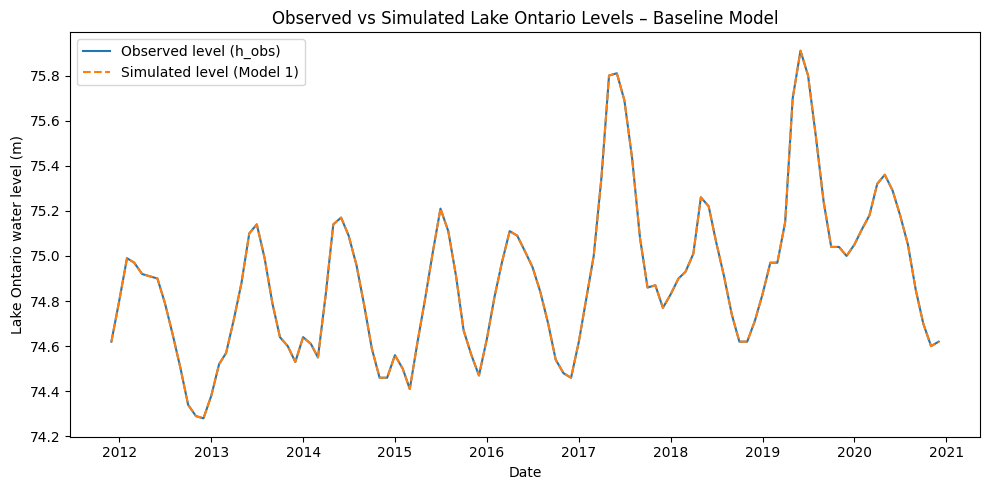

In [ ]:
## plot observed vs baseline-simulated levels

# Make sure Date is datetime and sorted
df_plot = df_model1.sort_values("Date").copy()
df_plot["Date"] = pd.to_datetime(df_plot["Date"])

plt.figure(figsize=(10, 5))

# Observed
plt.plot(df_plot["Date"], df_plot["h_obs"], label="Observed level (h_obs)")

# Simulated (Model 1)
plt.plot(df_plot["Date"], df_plot["h_sim"], label="Simulated level (Model 1)", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Lake Ontario water level (m)")
plt.title("Observed vs Simulated Lake Ontario Levels – Baseline Model")
plt.legend()
plt.tight_layout()
plt.show()

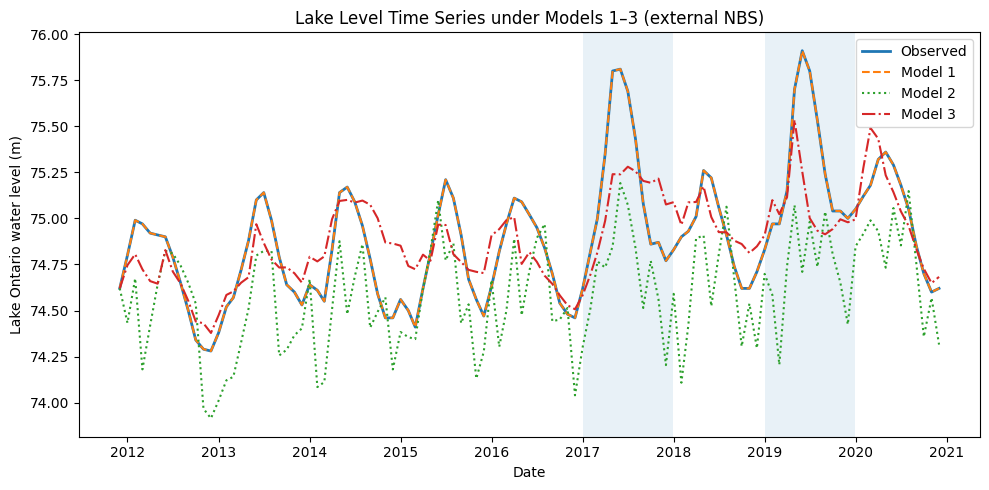

In [ ]:
# 4.2.1 Lake Level Time Series Comparison

df_plot = (
    df_model1[["Date", "h_obs", "h_sim"]]
    .rename(columns={"h_sim": "h_model1"})
    .merge(
        df_model2[["Date", "h_sim"]].rename(columns={"h_sim": "h_model2"}),
        on="Date",
        how="inner",
    )
    .merge(
        df_model3[["Date", "h_sim"]].rename(columns={"h_sim": "h_model3"}),
        on="Date",
        how="inner",
    )
)

plt.figure(figsize=(10, 5))
plt.plot(df_plot["Date"], df_plot["h_obs"], label="Observed", linewidth=2)
plt.plot(df_plot["Date"], df_plot["h_model1"], "--", label="Model 1")
plt.plot(df_plot["Date"], df_plot["h_model2"], ":", label="Model 2")
plt.plot(df_plot["Date"], df_plot["h_model3"], "-.", label="Model 3")

plt.xlabel("Date")
plt.ylabel("Lake Ontario water level (m)")
plt.title("Lake Level Time Series under Models 1–3 (external NBS)")
plt.legend()
for yr in [2017, 2019]:
    plt.axvspan(pd.Timestamp(f"{yr}-01-01"),
                pd.Timestamp(f"{yr}-12-31"),
                alpha=0.1)
plt.tight_layout()
plt.show()


In [ ]:
# ## plot observed vs baseline-simulated levels

# # Make sure Date is datetime and sorted
# df_plot = df_model1.sort_values("Date").copy()
# df_plot["Date"] = pd.to_datetime(df_plot["Date"])

# plt.figure(figsize=(10, 5))

# # Simulated
# for i, df_model in enumerate([df_model1, df_model2, df_model3]):
#   df_plot = df_model.sort_values("Date").copy()
#   df_plot["Date"] = pd.to_datetime(df_plot["Date"])
#   plt.plot(df_plot["Date"], df_plot["h_sim"], label=f"Simulated level (Model {i+1})")

# plt.xlabel("Date")
# plt.ylabel("Lake Ontario water level (m)")
# plt.title("Observed vs Simulated Lake Ontario Levels")
# plt.legend()
# plt.tight_layout()
# plt.show()

## Stakeholder-linked metrics

In [ ]:
from re import M
# h_low  = df["h_obs"].quantile(0.10)
# h_high = df["h_obs"].quantile(0.90)
# h_nav  = df["h_obs"].quantile(0.20)

Q_tot_obs = df["Q_out_obs"] + df["Q_ott"]
Q_tot_crit = np.nanpercentile(Q_tot_obs, 90)

# Penalty weightings
w_high = k_high
w_low = k_low
w_dh = k_dh
w_env = k_env

def high_penalty(h, h_low = h_low, h_high = h_high, w_low = 1.0, w_high =5.0):
  total = np.zeros(h.shape[0])
  for i in range(h.shape[0]):
    total[i] = np.log(1 + math.exp(h_high - h[i]))
  return total

def low_penalty(h, h_low = h_low, h_high = h_high, w_low = 1.0, w_high =5.0):
  total = np.zeros(h.shape[0])
  for i in range(h.shape[0]):
    total[i] = np.log(1 + math.exp(h[i] - h_low))
  return total

def dh_penalty(h, h_low = h_low, h_high = h_high, w_low = 1.0, w_high =5.0):
  total = np.zeros(h.shape[0]-1)
  for i in range(h.shape[0]-1):
    total[i] = math.pow(h[i+1] - h[i], 2)
  return total

def env_penalty(m, h, h_low = h_low, h_high = h_high, w_low = 1.0, w_high =5.0):
  total = np.zeros(h.shape[0])
  for i in range(h.shape[0]):
    if m[i] == 12 or m[i] < 6:
      total[i] = np.log(1 + math.exp(h_high - h[i]))
    else:
      total[i] = np.log(1 + math.exp(h[i] - h_low))
  return total

def compute_stakeholder_scores(df_model, name, print_=True):
  m = df_model["Month"].values
  h = df_model["h_sim"].values
  Q_out = df_model["Q_out_sim"].values
  Q_ott = df_model["Q_ott"].values

  high  = np.mean(high_penalty(h))
  low   = np.mean(low_penalty(h))
  dh    = np.mean(dh_penalty(h))
  env   = np.mean(env_penalty(m, h))
  total = w_high * high + w_low * low + w_dh * dh + w_env * env

  if print_:
    print (f"==={name} ===")
    print (f"High penalty: {high}")
    print (f"Low penalty: {low}")
    print (f"dh penalty: {dh}")
    print (f"Low+dh penalty: {low + dh}")
    print (f"Env penalty: {env}")
    print (f"Total penalty: {total}")
    print ()

  return total

compute_stakeholder_scores(df_model1, "Model 1 (historical outflow)")
compute_stakeholder_scores(df_model2, "Model 2 (plan-style rule)")
compute_stakeholder_scores(df_model3, "Model 3 (improved rule)")

===Model 1 (historical outflow) ===
High penalty: 0.9252947714034928
Low penalty: 0.925830196046202
dh penalty: 0.025831481481481424
Low+dh penalty: 0.9516616775276834
Env penalty: 0.9516826745871786
Total penalty: 2.067292983848612

===Model 2 (plan-style rule) ===
High penalty: 1.1167920151434463
Low penalty: 0.7492348156721301
dh penalty: 0.08173336873171333
Low+dh penalty: 0.8309681844038435
Env penalty: 0.9879069544280545
Total penalty: 2.145341590432901

===Model 3 (improved rule) ===
High penalty: 0.9263864930182188
Low penalty: 0.9100531792364258
dh penalty: 0.01286778170726227
Low+dh penalty: 0.922920960943688
Env penalty: 0.9183146835943431
Total penalty: 2.0329703906807755



np.float64(2.0329703906807755)

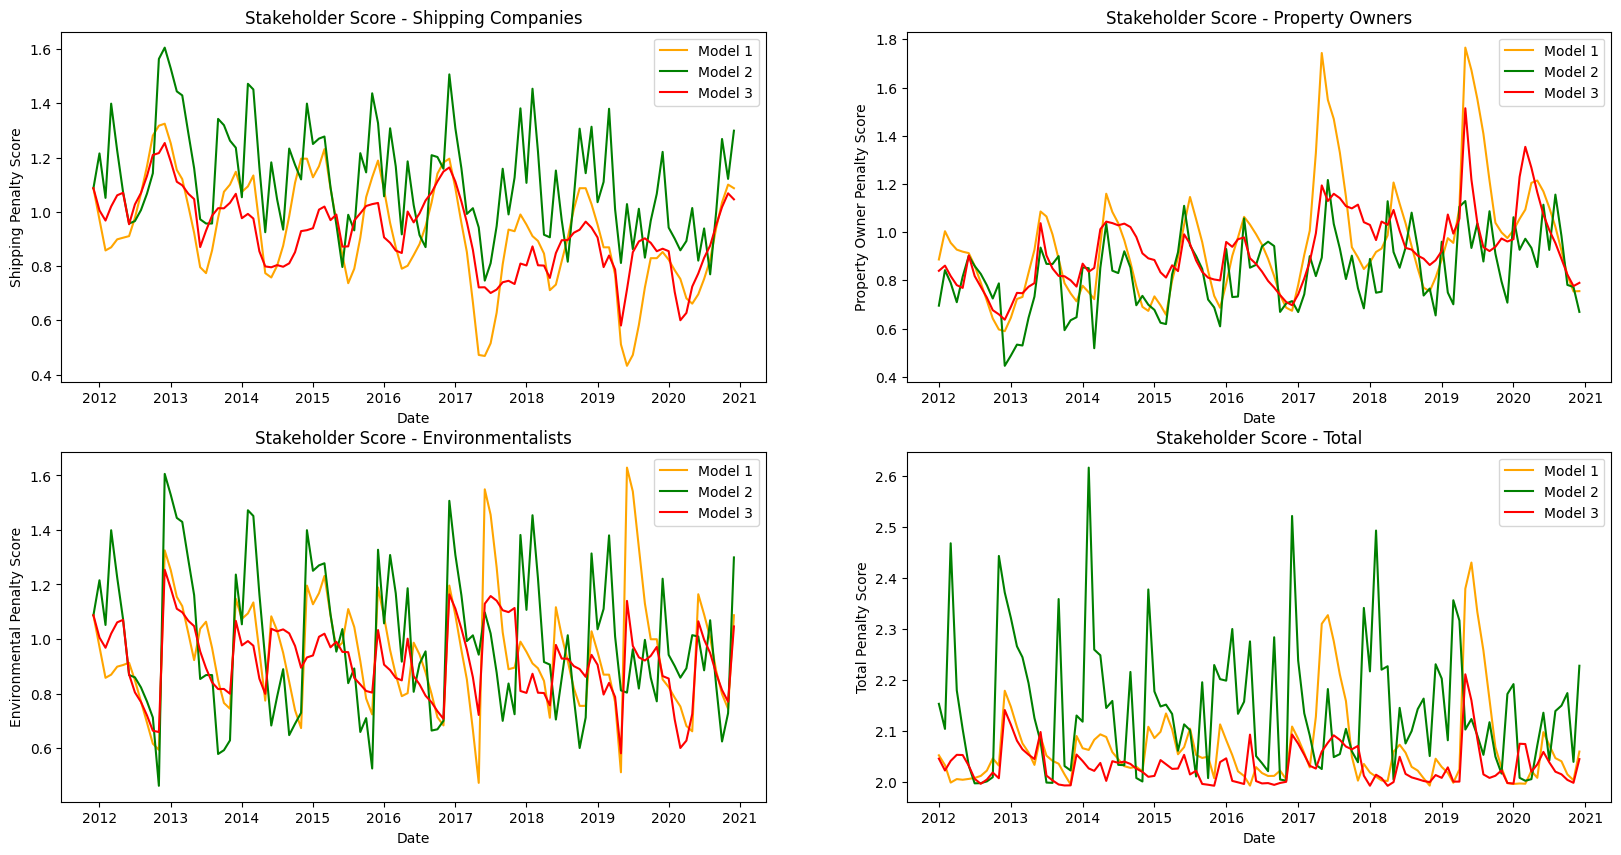

In [ ]:
#### Stakeholder Scores
dates = df_plot["Date"].values
model1_sim = df_model1["h_sim"].values
model2_sim = df_model2["h_sim"].values
model3_sim = df_model3["h_sim"].values

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(dates, high_penalty(model1_sim), color='orange', label="Model 1")
axs[0, 0].plot(dates, high_penalty(model2_sim), color='green', label="Model 2")
axs[0, 0].plot(dates, high_penalty(model3_sim), color='red', label="Model 3")
axs[0, 0].legend()
axs[0, 0].title.set_text("Stakeholder Score - Shipping Companies")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Shipping Penalty Score")

axs[0, 1].plot(dates[1:], low_penalty(model1_sim)[1:]+dh_penalty(model1_sim), color='orange', label="Model 1")
axs[0, 1].plot(dates[1:], low_penalty(model2_sim)[1:]+dh_penalty(model2_sim), color='green', label="Model 2")
axs[0, 1].plot(dates[1:], low_penalty(model3_sim)[1:]+dh_penalty(model3_sim), color='red', label="Model 3")
axs[0, 1].legend()
axs[0, 1].title.set_text("Stakeholder Score - Property Owners")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Property Owner Penalty Score")

axs[1, 0].plot(dates, env_penalty(df_model1["Month"].values, model1_sim), color='orange', label="Model 1")
axs[1, 0].plot(dates, env_penalty(df_model2["Month"].values, model2_sim), color='green', label="Model 2")
axs[1, 0].plot(dates, env_penalty(df_model3["Month"].values, model3_sim), color='red', label="Model 3")
axs[1, 0].legend()
axs[1, 0].title.set_text("Stakeholder Score - Environmentalists")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Environmental Penalty Score")

axs[1, 1].plot(dates[1:], w_high*high_penalty(model1_sim)[1:]+w_low*low_penalty(model1_sim)[1:]+w_dh*dh_penalty(model1_sim)+w_env*env_penalty(df_model1["Month"].values, model1_sim)[1:], color='orange', label="Model 1")
axs[1, 1].plot(dates[1:], w_high*high_penalty(model2_sim)[1:]+w_low*low_penalty(model2_sim)[1:]+w_dh*dh_penalty(model2_sim)+w_env*env_penalty(df_model1["Month"].values, model2_sim)[1:], color='green', label="Model 2")
axs[1, 1].plot(dates[1:], w_high*high_penalty(model3_sim)[1:]+w_low*low_penalty(model3_sim)[1:]+w_dh*dh_penalty(model3_sim)+w_env*env_penalty(df_model1["Month"].values, model3_sim)[1:], color='red', label="Model 3")
axs[1, 1].legend()
axs[1, 1].title.set_text("Stakeholder Score - Total")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Total Penalty Score")

plt.show()

/tmp/ipython-input-2378002496.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


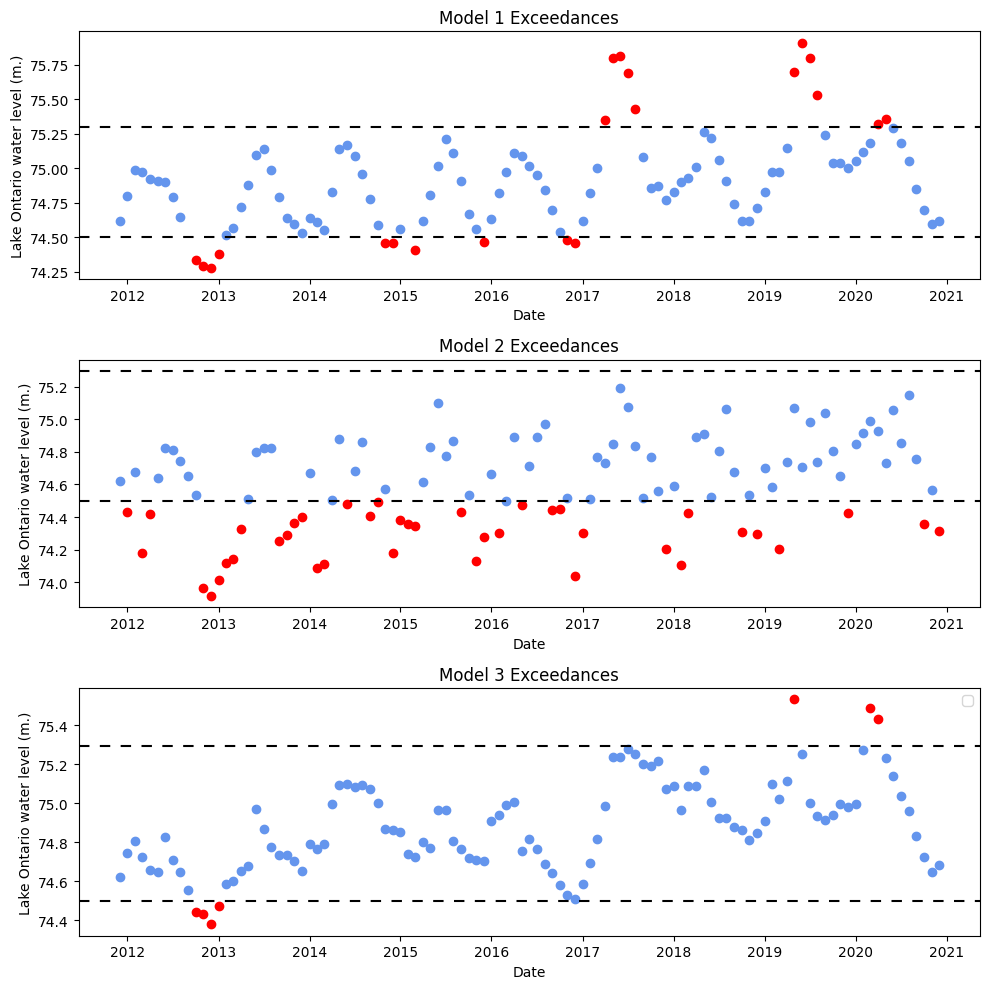

Model 1 exceedances: 21 / 109
Model 2 exceedances: 40 / 109
Model 3 exceedances: 7 / 109


In [ ]:
#### Threshold Exceedances
model1_noexceed = np.argwhere(np.logical_and(model1_sim > h_low, model1_sim < h_high))
model2_noexceed = np.argwhere(np.logical_and(model2_sim > h_low, model2_sim < h_high))
model3_noexceed = np.argwhere(np.logical_and(model3_sim > h_low, model3_sim < h_high))

model1_exceed = np.argwhere(np.logical_or(model1_sim < h_low, model1_sim > h_high))
model2_exceed = np.argwhere(np.logical_or(model2_sim < h_low, model2_sim > h_high))
model3_exceed = np.argwhere(np.logical_or(model3_sim < h_low, model3_sim > h_high))

fig, axs = plt.subplots(3, figsize=(10, 10))

axs[0].scatter(dates[model1_noexceed], model1_sim[model1_noexceed], color="cornflowerblue")
axs[0].scatter(dates[model1_exceed], model1_sim[model1_exceed], color="red")
axs[0].axhline(h_low, linestyle = "dashed", dashes=(5,5), color="black")
axs[0].axhline(h_high, linestyle = "dashed", dashes=(5,5), color="black")
axs[0].title.set_text("Model 1 Exceedances")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Lake Ontario water level (m.)")

axs[1].scatter(dates[model2_noexceed], model2_sim[model2_noexceed], color="cornflowerblue")
axs[1].scatter(dates[model2_exceed], model2_sim[model2_exceed], color="red")
axs[1].axhline(h_low, linestyle = "dashed", dashes=(5,5), color="black")
axs[1].axhline(h_high, linestyle = "dashed", dashes=(5,5), color="black")
axs[1].title.set_text("Model 2 Exceedances")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Lake Ontario water level (m.)")

axs[2].scatter(dates[model3_noexceed], model3_sim[model3_noexceed], color="cornflowerblue")
axs[2].scatter(dates[model3_exceed], model3_sim[model3_exceed], color="red")
axs[2].axhline(h_low, linestyle = "dashed", dashes=(5,5), color="black")
axs[2].axhline(h_high, linestyle = "dashed", dashes=(5,5), color="black")
axs[2].title.set_text("Model 3 Exceedances")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Lake Ontario water level (m.)")

plt.legend()
plt.tight_layout()
plt.show()

print(f'Model 1 exceedances: {model1_exceed.shape[0]} / {model1_sim.shape[0]}')
print(f'Model 2 exceedances: {model2_exceed.shape[0]} / {model2_sim.shape[0]}')
print(f'Model 3 exceedances: {model3_exceed.shape[0]} / {model3_sim.shape[0]}')

In [ ]:
from tqdm import tqdm

# Stochastic Trials
def generate_random_nbs(df):
  df_random = df.copy()[:-1]
  for i in range(1, 13):
    nonzeros = np.nonzero(df_random["Month"]==i)
    nbs_values = np.zeros(len(nonzeros[0]))
    for j, index in enumerate(nonzeros[0]):
      nbs_values[j] = df_random["NBS"][index]
    mean = np.mean(nbs_values)
    stdev = np.std(nbs_values)
    rand_nbs = np.random.normal(mean, stdev, len(nonzeros[0]))
    for j, index in enumerate(nonzeros[0]):
      df_random.loc[index, "NBS"] = rand_nbs[j]
  return df_random

NUM_TRIALS = 10000

model1_scores = np.zeros((NUM_TRIALS, 6))
model2_scores = np.zeros((NUM_TRIALS, 6))
model3_scores = np.zeros((NUM_TRIALS, 6))
for i in tqdm(range(NUM_TRIALS)):
  random_df = generate_random_nbs(df)
  df_model1_rand = simulate_with_rule(random_df, alpha, Q_out_model1)
  df_model2_rand = simulate_with_rule(random_df, alpha, Q_outmodel2)
  df_model3_rand = simulate_with_rule(random_df, alpha, Q_out_model3)

  model1_scores[i, 0] = np.argwhere(np.logical_or(df_model1_rand['h_sim'] < h_low, df_model1_rand['h_sim'] > h_high)).shape[0] / df_model1_rand['h_sim'].shape[0]
  model1_scores[i, 1] = np.mean(high_penalty(df_model1_rand['h_sim']))
  model1_scores[i, 2] = np.mean(low_penalty(df_model1_rand['h_sim']))
  model1_scores[i, 3] = np.mean(dh_penalty(df_model1_rand['h_sim']))
  model1_scores[i, 4] = np.mean(env_penalty(df_model1_rand['Month'], df_model1_rand['h_sim']))

  model2_scores[i, 0] = np.argwhere(np.logical_or(df_model2_rand['h_sim'] < h_low, df_model2_rand['h_sim'] > h_high)).shape[0] / df_model2_rand['h_sim'].shape[0]
  model2_scores[i, 1] = np.mean(high_penalty(df_model2_rand['h_sim']))
  model2_scores[i, 2] = np.mean(low_penalty(df_model2_rand['h_sim']))
  model2_scores[i, 3] = np.mean(dh_penalty(df_model1_rand['h_sim']))
  model2_scores[i, 4] = np.mean(env_penalty(df_model2_rand['Month'], df_model2_rand['h_sim']))

  model3_scores[i, 0] = np.argwhere(np.logical_or(df_model3_rand['h_sim'] < h_low, df_model3_rand['h_sim'] > h_high)).shape[0] / df_model3_rand['h_sim'].shape[0]
  model3_scores[i, 1] = np.mean(high_penalty(df_model3_rand['h_sim']))
  model3_scores[i, 2] = np.mean(low_penalty(df_model3_rand['h_sim']))
  model3_scores[i, 3] = np.mean(dh_penalty(df_model1_rand['h_sim']))
  model3_scores[i, 4] = np.mean(env_penalty(df_model3_rand['Month'], df_model3_rand['h_sim']))

model1_scores[:, 5] = w_high * model1_scores[:, 1] + w_low * model1_scores[:, 2] + w_dh * model1_scores[:, 3] + w_env * model1_scores[:, 4]
model2_scores[:, 5] = w_high * model2_scores[:, 1] + w_low * model2_scores[:, 2] + w_dh * model2_scores[:, 3] + w_env * model2_scores[:, 4]
model3_scores[:, 5] = w_high * model3_scores[:, 1] + w_low * model3_scores[:, 2] + w_dh * model3_scores[:, 3] + w_env * model3_scores[:, 4]

for i, scores in enumerate([model1_scores, model2_scores, model3_scores]):
  print(f'\nModel {i+1}')
  print(f'Exceedances: mean {np.mean(scores[:, 0])}, std {np.std(scores[:, 0])}, min {np.min(scores[:, 0])}, max {np.max(scores[:, 0])}')
  print(f'Shipping: mean {np.mean(scores[:, 1])}, std {np.std(scores[:, 1])}, min {np.min(scores[:, 1])}, max {np.max(scores[:, 1])}')

  homeowners_score = scores[:, 2] + scores[:, 3]
  print(f'Owners: mean {np.mean(homeowners_score)}, std {np.std(homeowners_score)}, min {np.min(homeowners_score)}, max {np.max(homeowners_score)}')
  print(f'Environ: mean {np.mean(scores[:, 4])}, std {np.std(scores[:, 4])}, min {np.min(scores[:, 4])}, max {np.max(scores[:, 4])}')
  print(f'Total: mean {np.mean(scores[:, 5])}, std {np.std(scores[:, 5])}, min {np.min(scores[:, 5])}, max {np.max(scores[:, 5])}')


 16%|█▌        | 1582/10000 [01:58<10:08, 13.84it/s]